# EMPCA on QSOs #
This notebook documents work on applying EMPCA to QSO spectra
to generate new QSO PCA templates.  It uses DR7 QSOs with
Hewitt & Wild redshifts, organized by Yue Shen.  Stephen Bailey
applied EMCPA using https://github.com/sbailey/empca.

In [1]:
%pylab inline
import fitsio
import numpy as np
from empca import empca, Model

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = fitsio.read('training_sample_dr7_cleaned.fits', 1)
flux = data['FLUXNORM'][0]
err = data['ERRNORM'][0]
wave = data['RESTWAVE'][0]
redshifts = data['ZHW'][0]

### Cleanup negative and tiny errors ###
In this sample, err=0 means ignore that data (i.e. infinite weight).
Resampling to the BOSS QSO template grid resulted in some negative and tiny
errors that should have been 0.0 instead.

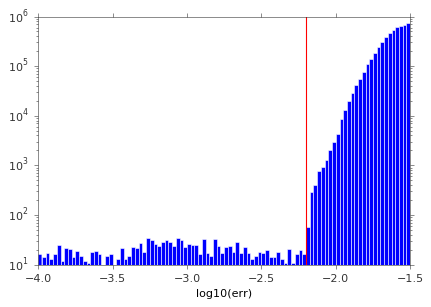

In [3]:
#- cleanup negative and tiny errors that should be infinite
hist(np.log10(err[err>0]), 100, (-4,-1.5), log=True)
axvline(-2.2, color='r')
xlabel('log10(err)')
ii = (err<10**-2.2)
err[ii] = 0.0

### Remove some questionable objects ###
Very low S/N, very strong BAL or metals, or otherwise non-standard QSOs that may hurt convergence for normal QSO templates

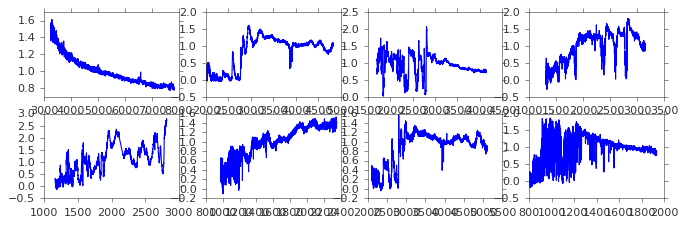

In [4]:
#- Remove some targets that don't look like typical QSOs (but aren't just BAL QSOs)
ibad = [21, 1170, 1935, 3859, 4487, 4832, 974, 5172]
figure(figsize=(10,3))
for i in range(len(ibad)):
    subplot(2,4,1+i)
    ii = err[ibad[i]]>0
    plot(wave[ii], flux[ibad[i],ii])

In [5]:
iikeep = ~np.in1d(np.arange(flux.shape[0]), ibad)
flux = flux[iikeep]
err = err[iikeep]
redshifts = redshifts[iikeep]

In [6]:
#- generate weights=1/err^2 while treating err=0 as actually meaning weights=0
weights = 1/(err+(err==0))**2 * (err>0)

### Trim to wavelengths that have coverage ###

For consideration: require a minimum of something like 25 spectra to include a wavelength.

[]

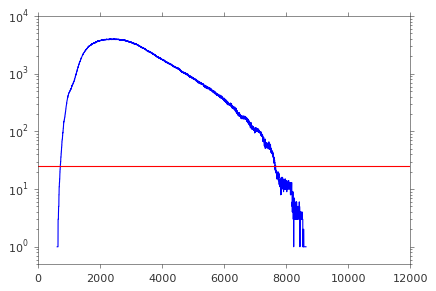

In [10]:
#- number of spectra covering a given wavelength
nspec_per_wave = np.sum(weights>0, axis=0)
plot(wave, nspec_per_wave)
axhline(25, color='r')
ylim(0.5, 1e4)
semilogy()

In [11]:
#- only consider wavelengths where we have >=25 spectra to make PCA fit semi-meaningful
#- UPDATE: just require 1 for now
ii = (nspec_per_wave >= 25)
# ii = (nspec_per_wave >= 1)
wave = wave[ii]
flux = flux[:,ii]
err = err[:,ii]
weights = weights[:,ii]

In [74]:
#- How much missing data is there?
print('missing data fraction', np.count_nonzero(err==0) / err.size)

missing data fraction 0.6622937788731689


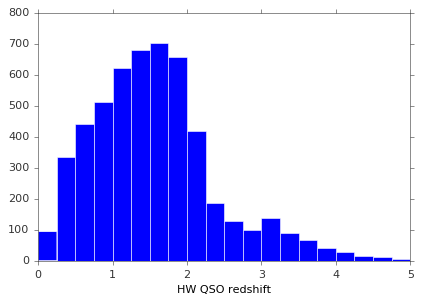

In [12]:
#- Plot n(z)
_ = hist(redshifts, 20, (0,5)); xlabel('HW QSO redshift')

### Renomalize spectra ###

Compare average spectra in bins of redshift -- they don't line up, resulting in
unconverged EMPCA templates with unphysical steps.  Fix that.
  * Generate average spectra in bins of redshift
  * Renormalize those average spectra to line then up for wavelengths >1300
  * Make a new average spectrum across all wavelengths
  * Normlized individual spectra to that new average spectrum

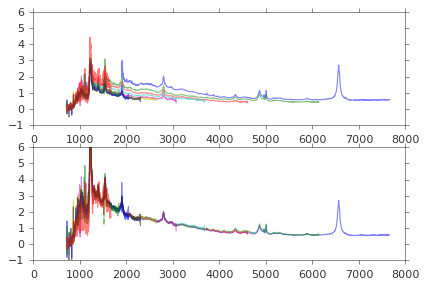

In [13]:
#- Compare average spectra in bins of redshift
#- Renormalize for wavelengths above 1300
zspec = list()
zwave = list()
iiwave = list()
for z in np.arange(0,5,0.5):
    zbin = (z <= redshifts) & (redshifts <= z+1)
    ii = np.sum(weights[zbin], axis=0)>0
    meanflux = np.average(flux[zbin][:,ii], weights=weights[zbin][:,ii], axis=0)
    if len(zspec) == 0:
        normflux = meanflux
        zspec.append(meanflux)
        iiwave.append(ii)
        zwave.append(wave[ii])
    else:
        lo = np.in1d(zwave[-1], wave[ii]) & (zwave[-1] > 1300)
        hi = np.in1d(wave[ii], zwave[-1]) & (wave[ii] > 1300)
        normflux = meanflux * (np.median(zspec[-1][lo]) / np.median(meanflux[hi]))
        zspec.append(normflux)
        iiwave.append(wave[ii])
        zwave.append(wave[ii])
    
    subplot(211); plot(wave[ii], meanflux, alpha=0.5); ylim(-1, 6)
    subplot(212); plot(wave[ii], normflux, alpha=0.5); ylim(-1, 6)

### Combine renormalized spectra into a meanflux spectrum over all wavelengths ###

(-2, 8)

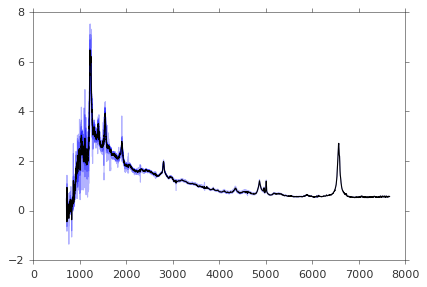

In [14]:
#- Combine renormalized spectra
tmpflux = np.zeros((len(zspec), len(wave)))
tmpweights = np.zeros_like(tmpflux)
for i in range(len(zspec)):
    ii = np.in1d(wave, zwave[i])
    tmpflux[i, ii] = zspec[i]
    tmpweights[i, ii] = 1.0

meanflux = np.average(tmpflux, weights=tmpweights, axis=0)
for i in range(len(zwave)):
    plot(zwave[i], zspec[i], 'b-', alpha=0.3)
plot(wave, meanflux, 'k-')
ylim(-2, 8)

In [15]:
#- Renormalize data to match that new meanflux
normflux = np.zeros_like(flux)
normerr = np.zeros_like(flux)
for i in range(flux.shape[0]):
    ii = err[i]>0
    scale = (np.median(meanflux[ii]) / np.median(flux[i,ii]))
    normflux[i] = flux[i] * scale
    normerr[i] = err[i] * scale

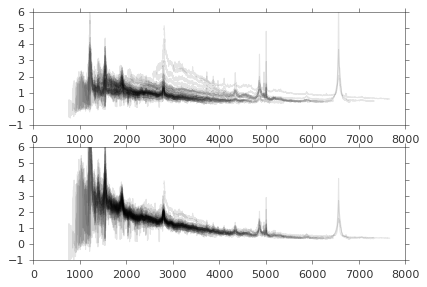

In [17]:
#- Plot some before/after examples
for i in range(0,flux.shape[0],100):
    ii = (err[i]>0)
    subplot(211)
    plot(wave[ii], flux[i,ii], 'k-', alpha=0.1); ylim(-1, 6)
    subplot(212)
    plot(wave[ii], normflux[i,ii], 'k-', alpha=0.1); ylim(-1, 6)

### Define some utility functions ###

In [18]:
#- Flip eigenvectors as needed to make 3000-3500 positive for comparison consistency
def standardize_model(model, wave):
    iiHalpha = (3000 < wave) & (wave < 3500)
    for i in range(model.nvec):
        sign = np.sign(np.sum(model.eigvec[i][iiHalpha]))
        model.eigvec[i] /= sign
        model.coeff[:,i] /= sign

def plot_model(model, wave, nofig=False):
    if not nofig:
        figure(figsize=(6,6))
    for i in range(model.nvec):
        offset = -i*0.05
        plot(wave, model.eigvec[i] + offset, alpha=1-float(i)/model.nvec)
        axhline(offset, color='k', alpha=0.1)
    ylim(-i*0.05-0.05, 0.05)

## First pass EMPCA with 5 vectors ##

Does not appear to be converging and it still has crazy eigenvectors after 20 iterations.
Not shown here: they look better after 4 or 5 iterations, but still not very good.

       iter        R2             rchi2
EMPCA  1/20      -0.00654629    684.34250767
EMPCA  2/20      -0.00434822    174.47197666
EMPCA  3/20       0.05274105    301.87573883
EMPCA  4/20      -0.28860210    947.29778397
EMPCA  5/20      -0.94152676    841.71076115
EMPCA  6/20       0.11527524    504.10592891
EMPCA  7/20       0.59253768    142.33528980
EMPCA  8/20      -1.11086522    245.40947191
EMPCA  9/20      -5.46578354   1142.27430717
EMPCA 10/20      -6.06810028   1272.79119625
EMPCA 11/20     -10.30393469  12475.01939806
EMPCA 12/20    -184.96683659  68735.23132686
EMPCA 13/20     -18.07988319  13144.34822515
EMPCA 14/20     -12.68124421   6534.16611904
EMPCA 15/20     -31.73955198   8890.46653658
EMPCA 16/20      -0.30185037    275.45397696
EMPCA 17/20      -2.18504780    887.47195267
EMPCA 18/20     -10.14185130   2203.39800932
EMPCA 19/20      -0.57160354    286.67988551
EMPCA 20/20      -0.18323879    519.46719929
R2: -0.204432393322


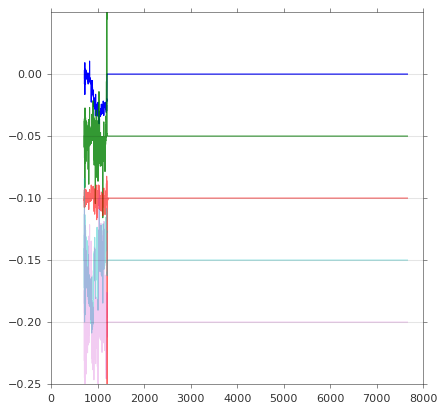

In [19]:
normweights = 1/(normerr + (normerr==0))**2 * (normerr>0)
model = empca(normflux, normweights, niter=20, nvec=5)
standardize_model(model, wave)
plot_model(model, wave)

## Weight by S/N instead of just 1/err or 1/err^2 ##

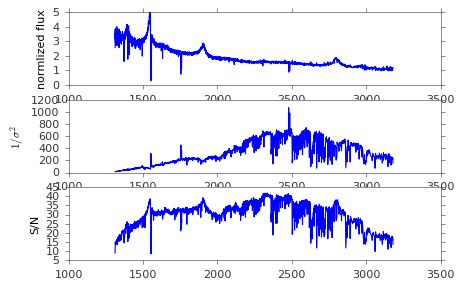

In [28]:
from scipy.signal import medfilt

i = 3771
ii = (normerr[i]>0)
medflux = medfilt(normflux[i, ii], 5)
snr = medflux/normerr[i,ii]

subplot(311); plot(wave[ii], normflux[i, ii]); ylabel('normlized flux')
subplot(312); plot(wave[ii], normweights[i, ii]); ylabel('$1/\sigma^2$')
subplot(313); plot(wave[ii], snr); ylabel('S/N')

In [42]:
#- use fit to meanflux for signal instead of noisy observed flux
snr = np.zeros_like(normflux)
reference = meanflux.copy()
ii = (wave < 1218)
reference[ii] = medfilt(meanflux[ii], 51)
ii = (wave < 715)
reference[ii] = 0.1
reference.clip(0,1e6)
# plot(wave, reference)

for i in range(normflux.shape[0]):
    ii = (normerr[i]>0)
    scale = np.dot(normflux[i,ii], reference[ii]) / np.dot(reference[ii], reference[ii])
    signal = reference*scale
    snr[i] = signal / (normerr[i] + (normerr[i]==0)) * (normerr[i]>0)

       iter        R2             rchi2
EMPCA  1/ 5       0.01816396     91.20240509
EMPCA  2/ 5      -3.92890901    155.26141843
EMPCA  3/ 5       0.36533001     16.17694880
EMPCA  4/ 5       0.70753565      6.62142353
EMPCA  5/ 5       0.77934820      4.85495148
R2: 0.929208699369


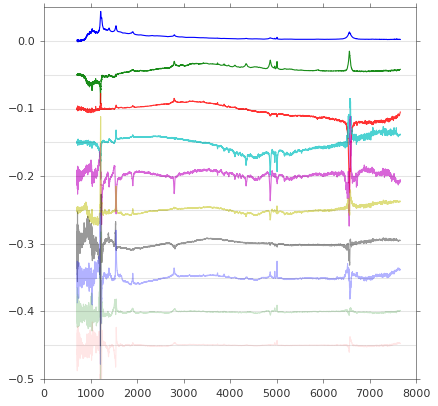

In [44]:
#- Rerun EMPCA weighting by S/N instead of 1/err^2
m5 = empca(normflux, snr, niter=5, nvec=10)
standardize_model(m5, wave)
plot_model(m5, wave)

       iter        R2             rchi2
EMPCA  1/20       0.01816396     91.20240509
EMPCA  2/20      -3.92890901    155.26141843
EMPCA  3/20       0.36533001     16.17694880
EMPCA  4/20       0.70753565      6.62142353
EMPCA  5/20       0.77934820      4.85495148
EMPCA  6/20       0.83551382      3.46189886
EMPCA  7/20       0.69254521      7.45763015
EMPCA  8/20       0.84730934      3.25395367
EMPCA  9/20       0.77859357      5.93818489
EMPCA 10/20       0.13773522     26.58431187
EMPCA 11/20      -3.89670593    156.77841623
EMPCA 12/20      -4.63308803    138.20405900
EMPCA 13/20      -3.18302201    108.28397992
EMPCA 14/20     -45.61403322   1053.53296256
EMPCA 15/20     -24.98347882    712.72319728
EMPCA 16/20      -3.60357262    131.41306306
EMPCA 17/20      -0.54073536     41.53072822
EMPCA 18/20      -1.10477333     52.84874104
EMPCA 19/20      -4.13375498    121.44868668
EMPCA 20/20      -0.15714732     28.46676604
R2: 0.921800835902


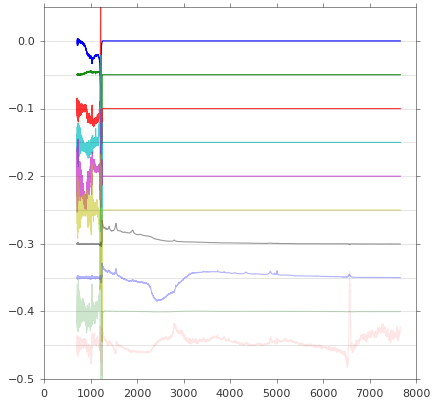

In [45]:
#- Try 20 iterations - oops
m20 = empca(normflux, snr, niter=20, nvec=10)
standardize_model(m20, wave)
plot_model(m20, wave)

In [46]:
model = m5

In [300]:
#- Save eigenvectors
from astropy.io import fits
hdr = fits.Header()
hdr['COEFF0'] = np.log10(wave[0])
hdr['COEFF1'] = 0.0001
hdr['OBJECT'] = 'QSO'
### fits.writeto('spEigenQSO-EMPCA.fits', model.eigvec.astype(np.float32), header=hdr, clobber=True)

In [299]:
#- Save a cleaned up version
cleanmodel = model.eigvec.copy()
lo = (wave<1218)
hi = (wave>8500)
ix = np.where(hi)[0][0]
for i in range(cleanmodel.shape[0]):
    cleanmodel[i,lo] = medfilt(cleanmodel[i,lo], 31)
    cleanmodel[i,hi] = cleanmodel[i,ix] 

origwave = data['RESTWAVE'][0].copy()
fullclean = np.zeros((cleanmodel.shape[0], len(origwave)))
ii = np.in1d(origwave, wave)
fullclean[:,ii] = cleanmodel

hdr = fits.Header()
hdr['COEFF0'] = np.log10(origwave[0])
hdr['COEFF1'] = 0.0001
hdr['OBJECT'] = 'QSO'
### fits.writeto('spEigenQSO-EMPCA-cleaned.fits', fullclean.astype(np.float32), header=hdr, clobber=True)

In [47]:
chi2 = (normflux - model.model)**2  / (normerr + (normerr==0))**2 * (normerr>0)
chi2 = np.sum(chi2, axis=1)
assert len(chi2) == normflux.shape[0]
rchi2 = list()
for i in range(normflux.shape[0]):
    ngood = np.count_nonzero(normerr[i]>0)
    rchi2.append(chi2[i]/(ngood+10))

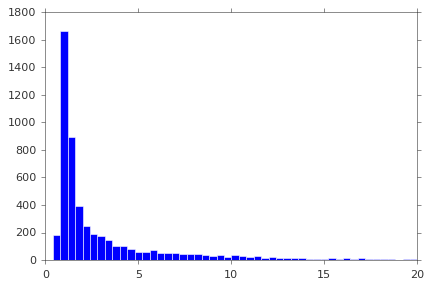

In [48]:
_ = hist(rchi2, 50, (0,20))

4621 61.2404282924


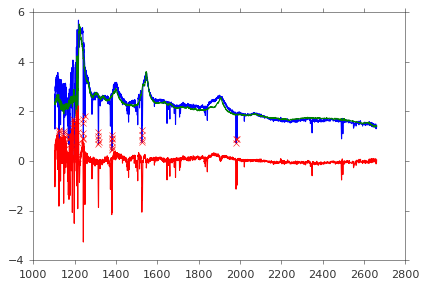

In [70]:
#- inspect some targets with poor reduced chi2
# j = -1
j += 1
rchi2 = np.asarray(rchi2)
i = np.where((50<rchi2) & (rchi2<1e6))[0][j]
print(i, rchi2[i])
ii = (normerr[i]>0)
plot(wave[ii], normflux[i, ii])
plot(wave[ii], model.model[i, ii])
plot(wave[ii], normflux[i,ii] - model.model[i, ii])

chi = (normflux[i,ii] - model.model[i,ii]) / normerr[i,ii]
medflux = medfilt(normflux[i, ii], 51)
iibad = (normflux[i,ii] < 0.5*medflux) & (chi < -5)
plot(wave[ii][iibad], normflux[i,ii][iibad], 'rx')

# plot(wave[ii], chi)

In [313]:
#- Note to self: index 92 is really noisy but actually a QSO

## Compare to idlspec2d eigentemplates ##

In [62]:
eigenboss = fits.getdata('/Users/sbailey/boss/svn/idlspec2d/templates/spEigenQSO-55732.fits')
origwave = data['RESTWAVE'][0]
ii = np.in1d(origwave, wave)
mboss = Model(eigenboss[:,ii], normflux, normweights)

In [63]:
boss_chi2 = (normflux - mboss.model)**2  / (normerr + (normerr==0))**2 * (normerr>0)
boss_chi2 = np.sum(boss_chi2, axis=1)
assert len(boss_chi2) == normflux.shape[0]
boss_rchi2 = list()
for i in range(normflux.shape[0]):
    ngood = np.count_nonzero(normerr[i]>0)
    boss_rchi2.append(boss_chi2[i]/(ngood+10))

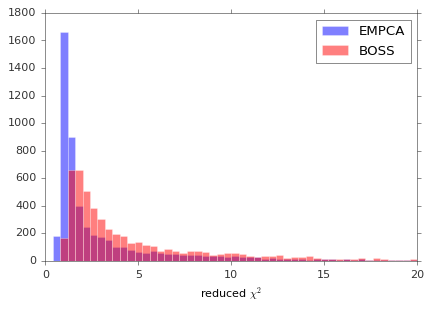

In [64]:
_ = hist(rchi2, 50, (0,20), alpha=0.5, label='EMPCA')
_ = hist(boss_rchi2, 50, (0,20), color='r', alpha=0.5, label='BOSS')
legend()
xlabel('reduced $\chi^2$')

# Other Attempts #

## Mask BAL and metals and refit ##
Doesn't make much of a difference by eye

In [65]:
chi = (normflux - model.model) / (normerr + (normerr==0)) * (normerr>0)
medflux = np.zeros_like(normflux)
for i in range(normflux.shape[0]):
    medflux[i] = medfilt(normflux[i])
    
bad = (normflux<0.5*medflux) & (chi < -5)

In [66]:
m2 = empca(normflux, snr * ~bad, niter=5, nvec=10)
standardize_model(m2, wave)

       iter        R2             rchi2
EMPCA  1/ 5       0.01814840     91.22832046
EMPCA  2/ 5      -3.95725042    156.94062662
EMPCA  3/ 5       0.38023890     15.70903297
EMPCA  4/ 5       0.70392698      6.70436173
EMPCA  5/ 5       0.78171218      4.78095458
R2: 0.931846729409


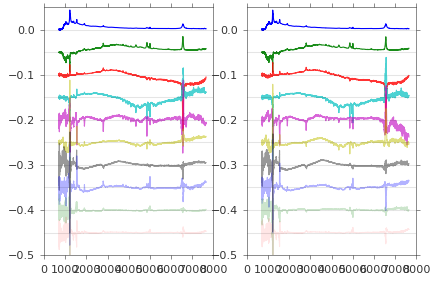

In [67]:
subplot(121); plot_model(model, wave, nofig=True)
subplot(122); plot_model(m2, wave, nofig=True)

## Subsample before doing EMPCA ##

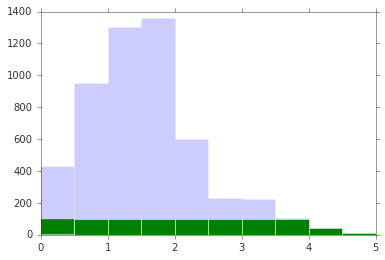

In [74]:
import random
keep = list()
for z in np.arange(0, 5, 0.5):
    ii = np.where((z <= redshifts) & (redshifts < z+0.5))[0]
    if len(ii) > 100:
        keep.append(random.sample(ii, 100))
    else:
        keep.append(ii)

keep = np.concatenate(keep)
subflux = normflux[keep]
suberr = normflux[keep]
subz = redshifts[keep]

_ = hist(redshifts, 10, (0,5), alpha=0.2)
_ = hist(subz, 10, (0,5))

       iter        R2             rchi2
EMPCA  1/ 5       0.00109811      0.99990677
EMPCA  2/ 5      -0.62938709      0.50020180
EMPCA  3/ 5      -0.73601927      0.61807946
EMPCA  4/ 5      -0.04689233      0.33372771
EMPCA  5/ 5       0.09005982      0.33601122
R2: 0.311173595261


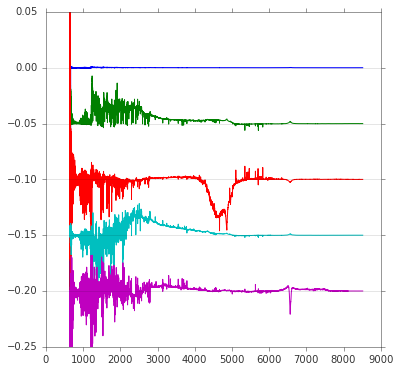

In [82]:
subweights = 1/(suberr + (suberr==0))**2 * (suberr>0)
ii = np.sum(subweights, axis=0) > 0
model = empca(subflux[:,ii], subweights[:,ii], niter=5, nvec=5)
standardize_model(model, wave[ii])
plot_model(model, wave[ii])

## Split samples into low and high redshift ##

In [71]:
iilow = (redshifts<1.5)
iihigh = (redshifts>=1.5)
loflux = normflux[iilow]
hiflux = normflux[iihigh]
loerr = normerr[iilow]
hierr = normerr[iihigh]

def trim_coverage(wave, flux, err):
    nspec_per_wave = np.sum(err>0, axis=0)
    ii = (nspec_per_wave >= 1)
    return wave[ii], flux[:,ii], err[:,ii]

lowave, loflux, loerr = trim_coverage(wave, loflux, loerr)
hiwave, hiflux, hierr = trim_coverage(wave, hiflux, hierr)

In [72]:
loweights = 1/(loerr + (loerr==0))**2 * (loerr>0)
lomodel = empca(loflux, loweights, niter=10, nvec=7)
hiweights = 1/(hierr + (hierr==0))**2 * (hierr>0)
himodel = empca(hiflux, hiweights, niter=10, nvec=7)

       iter        R2             rchi2
EMPCA  1/10       0.03724258    861.02695201
EMPCA  2/10       0.73828765    101.93284844
EMPCA  3/10       0.94761863     15.21141341
EMPCA  4/10       0.93006956     30.20230433
EMPCA  5/10       0.90694513     50.25625064
EMPCA  6/10       0.96390190     14.33938264
EMPCA  7/10       0.97159946      6.05707923
EMPCA  8/10       0.96204030     15.66206219
EMPCA  9/10       0.93984541     19.34836224
EMPCA 10/10       0.92848120     21.00014943
R2: 0.97749025008
       iter        R2             rchi2
EMPCA  1/10       0.05455871    560.77495490
EMPCA  2/10       0.35170219     77.35281326
EMPCA  3/10       0.45520461    179.51591586
EMPCA  4/10       0.80804639     22.04992626
EMPCA  5/10       0.84267026     10.02357950
EMPCA  6/10       0.86193474      7.02658885
EMPCA  7/10       0.86450899      6.58823169
EMPCA  8/10       0.86556549      6.44745513
EMPCA  9/10       0.86598280      6.23881104
EMPCA 10/10       0.86228331      6.39692801
R2

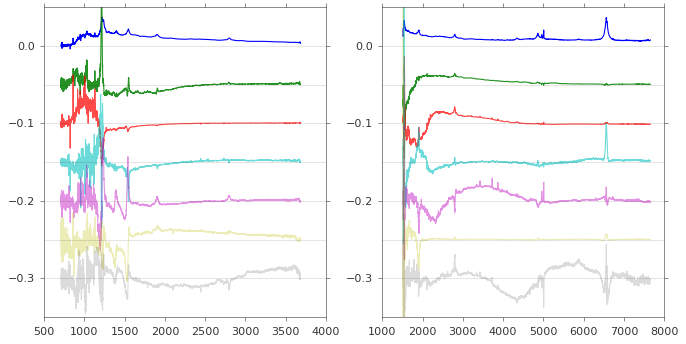

In [73]:
standardize_model(lomodel, lowave)
standardize_model(himodel, hiwave)
figure(figsize=(10,5))
subplot(121)
plot_model(himodel, hiwave, nofig=True)
subplot(122)
plot_model(lomodel, lowave, nofig=True)

In [76]:
#- Compare multiple random seed starting points
mx = list()
for i in range(5):
    tmp = empca(normflux, normweights, niter=5, nvec=5, randseed=i)
    standardize_model(tmp, wave=wave)
    mx.append(tmp)

       iter        R2             rchi2
EMPCA  1/ 5       0.01787454    682.97349803
EMPCA  2/ 5       0.68505362     53.97699411
EMPCA  3/ 5       0.83897006     18.15932636
EMPCA  4/ 5       0.87301954     12.72213445
EMPCA  5/ 5       0.88699221      9.90366619
R2: 0.900026475755
       iter        R2             rchi2
EMPCA  1/ 5      -0.00654629    684.34250767
EMPCA  2/ 5      -0.00434822    174.47197666
EMPCA  3/ 5       0.05274105    301.87573883
EMPCA  4/ 5      -0.28860210    947.29778397
EMPCA  5/ 5      -0.94152676    841.71076115
R2: 0.886049672077
       iter        R2             rchi2
EMPCA  1/ 5       0.03159505    676.05915799
EMPCA  2/ 5       0.44422772    107.36889226
EMPCA  3/ 5       0.79411184     50.75817549
EMPCA  4/ 5       0.81426563     52.31925693
EMPCA  5/ 5       0.84881604     27.39103282
R2: 0.884392490823
       iter        R2             rchi2
EMPCA  1/ 5       0.05809272    661.28610178
EMPCA  2/ 5       0.40250654    160.85736531
EMPCA  3/ 5       

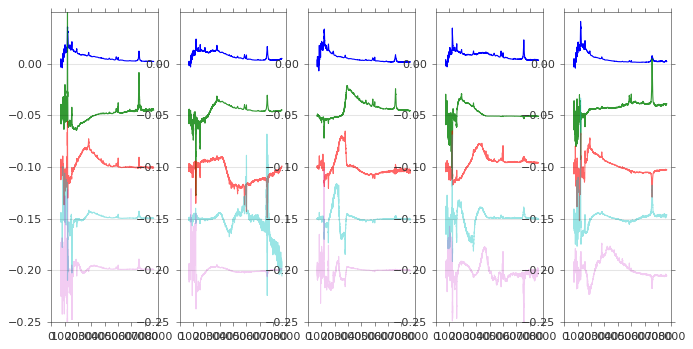

In [79]:
figure(figsize=(10,5))
for i in range(len(mx)):
    subplot(1, len(mx), 1+i)
    plot_model(mx[i], wave, nofig=True)

## Compare eigenvectors at different iterations ##

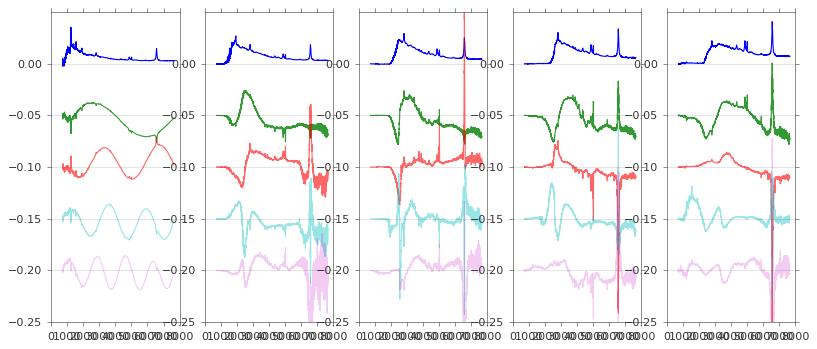

In [77]:
nvec = 5
eigvec = np.zeros((nvec,normflux.shape[1]))
eigvec[0] = meanflux / np.linalg.norm(meanflux)
xx = (wave - wave[0]) / (wave[-1] - wave[0]) * 2 * np.pi
for i in range(1,nvec):
    eigvec[i] = np.sin(i*xx)
    eigvec[i] /= np.linalg.norm(eigvec[i])
    for j in range(0,i):
        eigvec[i] -= eigvec[j] * np.dot(eigvec[j], eigvec[i])
    eigvec[i] /= np.linalg.norm(eigvec[i])
    
model = Model(eigvec, normflux, normweights)
model.solve_coeffs()
figure(figsize=(12,5))
for i in range(5):
    subplot(1,nvec,1+i)
    standardize_model(model, wave)
    plot_model(model, wave, nofig=True)
    model.solve_eigenvectors()
    model.solve_coeffs()

## Study variance ##

(0, 6000)

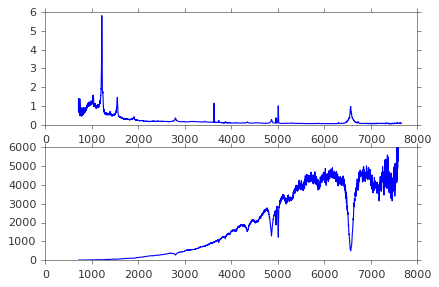

In [83]:
#- Variance of input data
tmpflux = normflux.copy()
tmpflux[normerr==0] = np.NaN
tmpweight = normweights.copy()
tmpweight[normweights==0] = np.NaN

subplot(211); plot(wave, np.nanstd(tmpflux, axis=0))
subplot(212); plot(wave, np.nanmedian(tmpweight, axis=0))
ylim(0,6000)

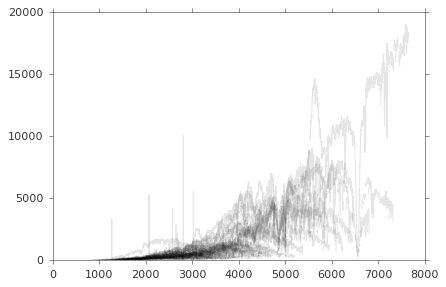

In [84]:
for i in range(0, normweights.shape[0], 100):
    y = normweights[i].copy()
    y[err[i]==0] = np.NaN
    plot(wave, y, 'k-', alpha=0.1)

       iter        R2             rchi2
EMPCA  1/ 5       0.04733999      4.19605649
EMPCA  2/ 5      -0.46514175      1.70927420
EMPCA  3/ 5      -0.25375959      1.27556302
EMPCA  4/ 5       0.79012358      0.23256266
EMPCA  5/ 5       0.78323694      0.25481975
R2: 0.918748933815


(-0.05, 0.35000000000000003)

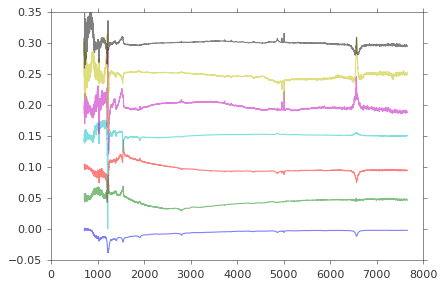

In [85]:
#- Normalize weights to be median constant in wavelength
normweights = 1/(normerr + (normerr==0))**2 * (normerr>0)
tmpweights = normweights.copy()
tmpweights[normweights==0] = np.NaN
medweights = np.nanmedian(tmpweights, axis=0)
normweights /= medweights
normweights = normweights.clip(0,5)  #- max allowed weight 5x median weight

model = empca(normflux, normweights, niter=5, nvec=7, randseed=None)
for i in range(model.nvec):
    plot(wave, model.eigvec[i] + i*0.05, alpha=0.5)
ylim(-0.05, i*0.05+0.05)

In [86]:
#- Yet another try: clip weights to 5*median at each wavelength
normweights = 1/(normerr + (normerr==0))**2 * (normerr>0)
for i in range(normweights.shape[1]):
    x = normweights[:,i]
    normweights[:,i] = x.clip(0, np.median(x[x>0]))

       iter        R2             rchi2
EMPCA  1/ 5       0.05257333    526.64599412
EMPCA  2/ 5      -0.44463728   1660.92222980
EMPCA  3/ 5       0.36993057    286.35263202
EMPCA  4/ 5       0.55602190    232.55663614
EMPCA  5/ 5       0.79866856     40.06307525
R2: 0.920543053678


(-0.05, 0.35000000000000003)

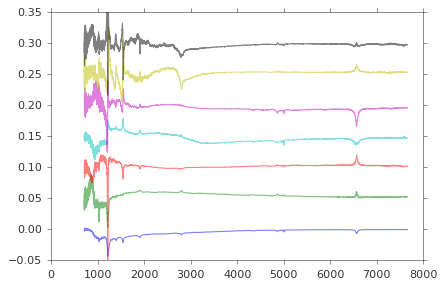

In [87]:
m3 = empca(normflux, normweights, niter=5, nvec=7, randseed=None)
for i in range(m3.nvec):
    plot(wave, m3.eigvec[i] + i*0.05, alpha=0.5)
ylim(-0.05, i*0.05+0.05)

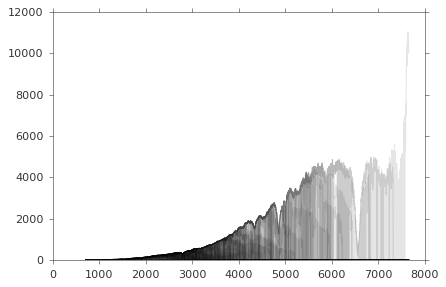

In [88]:
for i in range(0,normweights.shape[0], 100):
    plot(wave, normweights[i], 'k-', alpha=0.1)

## Delchambre 2014 WPCA ##

It is supposed to have better convergence properties, but that doesn't appear to be the case for these data

In [89]:
#- Let's try Delchambre's WPCA
import wpca

In [90]:
normweights = 1/(normerr + (normerr==0))**2 * (normerr>0)
%time pca = wpca.WPCA(n_components=5).fit(normflux, weights=normweights)

/Users/sbailey/anaconda/envs/desi/lib/python3.5/site-packages/wpca/wpca.py:116: RuntimeWarning: invalid value encountered in true_divide
  covar /= np.dot(weights.T, weights)


CPU times: user 2min 39s, sys: 2 s, total: 2min 41s
Wall time: 2min 41s


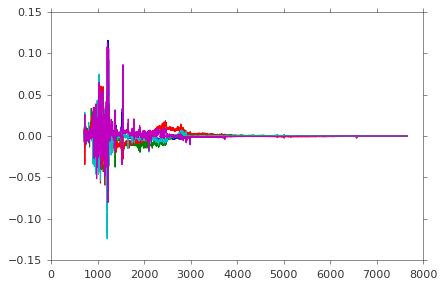

In [91]:
for i in range(pca.components_.shape[0]):
    plot(wave, pca.components_[i])